# 1.0 DATA PREPARATION

In [1]:
import pandas as pd
import numpy as np
import joblib
import plotnine as pn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
pn.options.dpi = 300

In [3]:
cdnow_raw_df = pd.read_csv('../data/cdnow.csv', index_col=0)

In [4]:
cdnow_raw_df.head(3)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00


In [5]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  object 
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.7+ MB


In [6]:
# convert to datetime
cdnow_df = (
    cdnow_raw_df
    .assign(date=lambda x: pd.to_datetime(x['date']))
    .dropna() 
)

In [7]:
cdnow_df['date'].dtype

dtype('<M8[ns]')

# 2.0 COHORT ANALYSIS

Only customers that have joined at the specific business day

## Get Range of Initial Purchases

In [8]:
cdnow_first_purchase_tbl = (
    cdnow_df
    .sort_values(['customer_id','date'])
    .groupby('customer_id')
    .first()
                            )

In [9]:
cdnow_first_purchase_tbl.head()

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33


In [10]:
cdnow_first_purchase_tbl['date'].min()

Timestamp('1997-01-01 00:00:00')

In [11]:
cdnow_first_purchase_tbl['date'].max()

Timestamp('1997-03-25 00:00:00')

## Visualize: All purchases within cohort

<Axes: xlabel='date'>

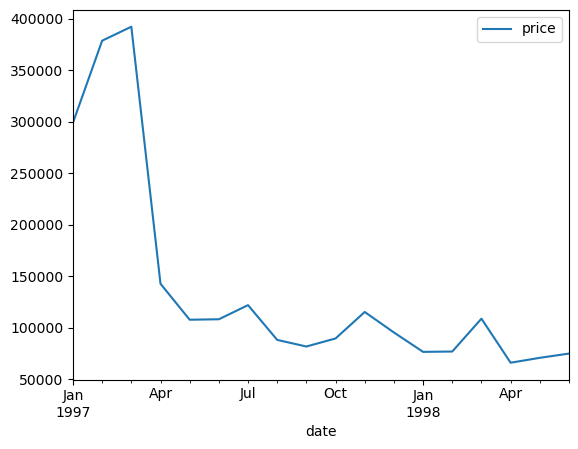

In [12]:
cdnow_df.reset_index() \
    .set_index('date') \
    [['price']] \
    .resample(rule='MS') \
    .sum() \
    .plot()

## Visualize: Individual Customer Purchases

In [13]:
# Select a subset of customer IDs
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[:12]

/tmp/ipykernel_218976/2476615928.py:26: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observ

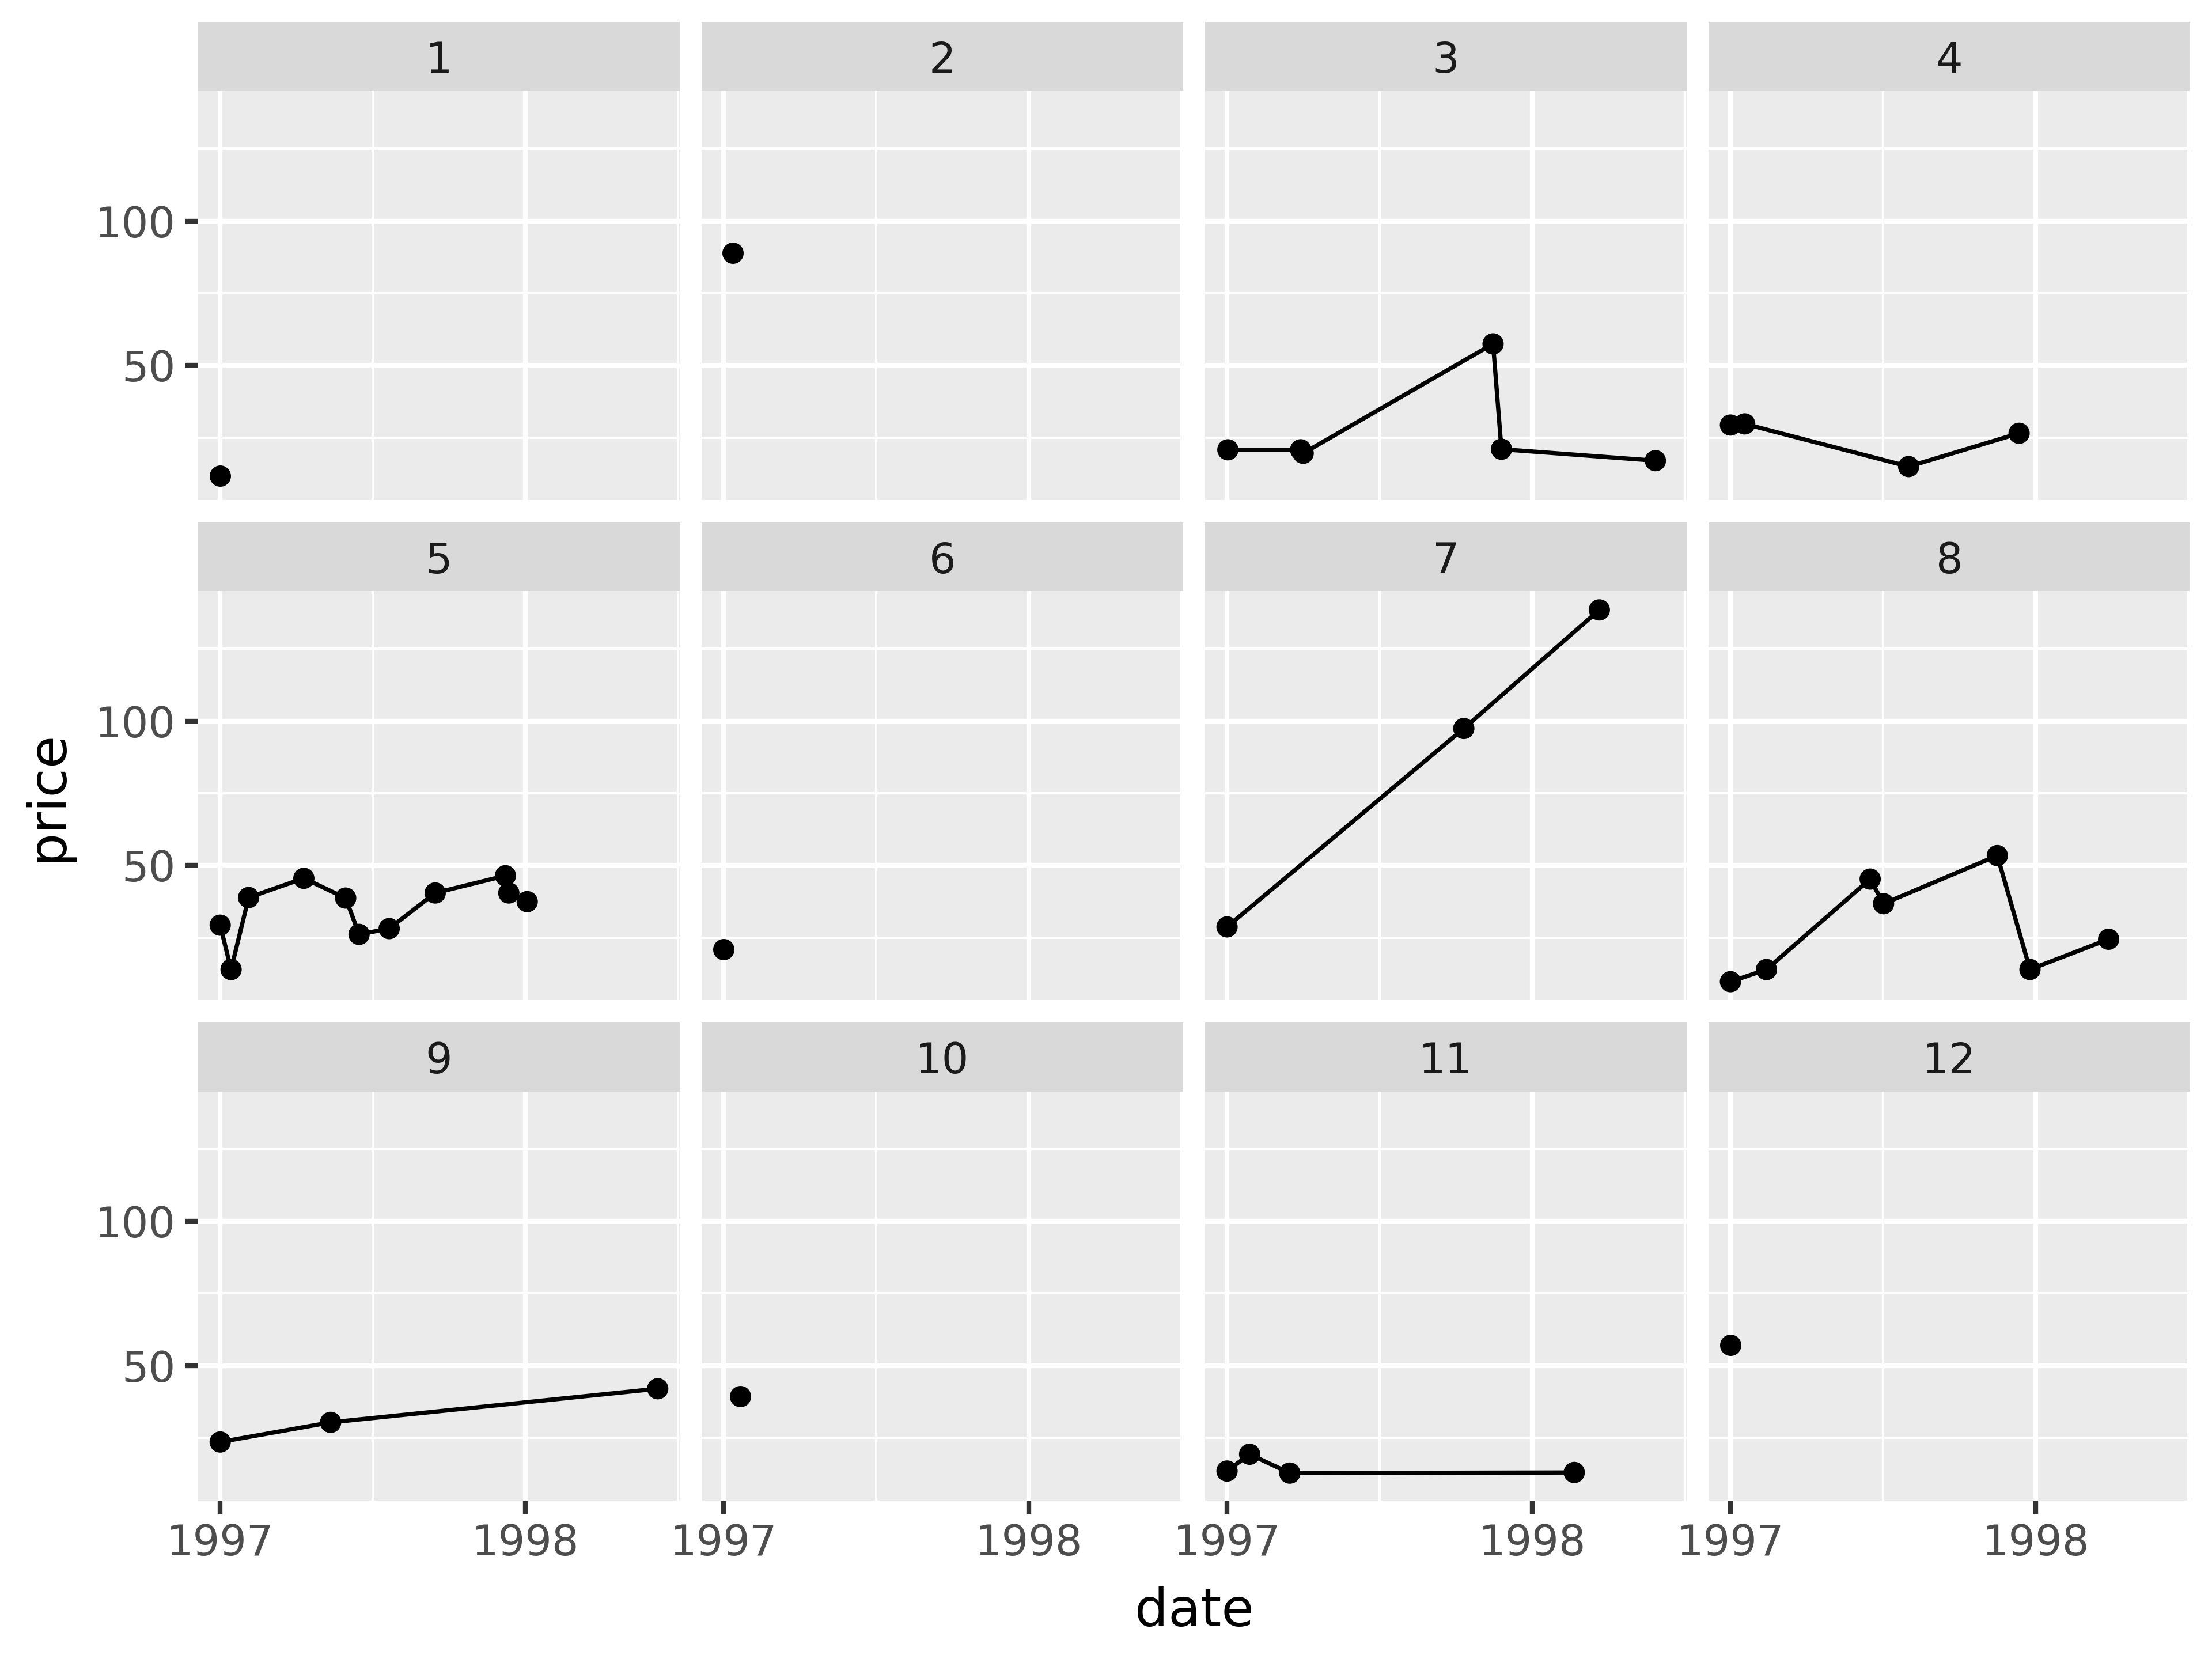

In [14]:
# ggplot API
# Filter the DataFrame for the selected customer IDs
cdnow_cust_id_subset_df = (
    cdnow_df[cdnow_df['customer_id'].isin(ids_selected)]
    .groupby(['customer_id', 'date'])
    .sum()
    .reset_index()
)

# Create the plot
plot = (
    pn.ggplot(
        cdnow_cust_id_subset_df,
        pn.aes('date', 'price', group='customer_id')
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.facet_wrap('~customer_id')
    + pn.scale_x_date(
        date_breaks='1 year',
        date_labels='%Y'
    )
)

# Display the plot
print(plot)

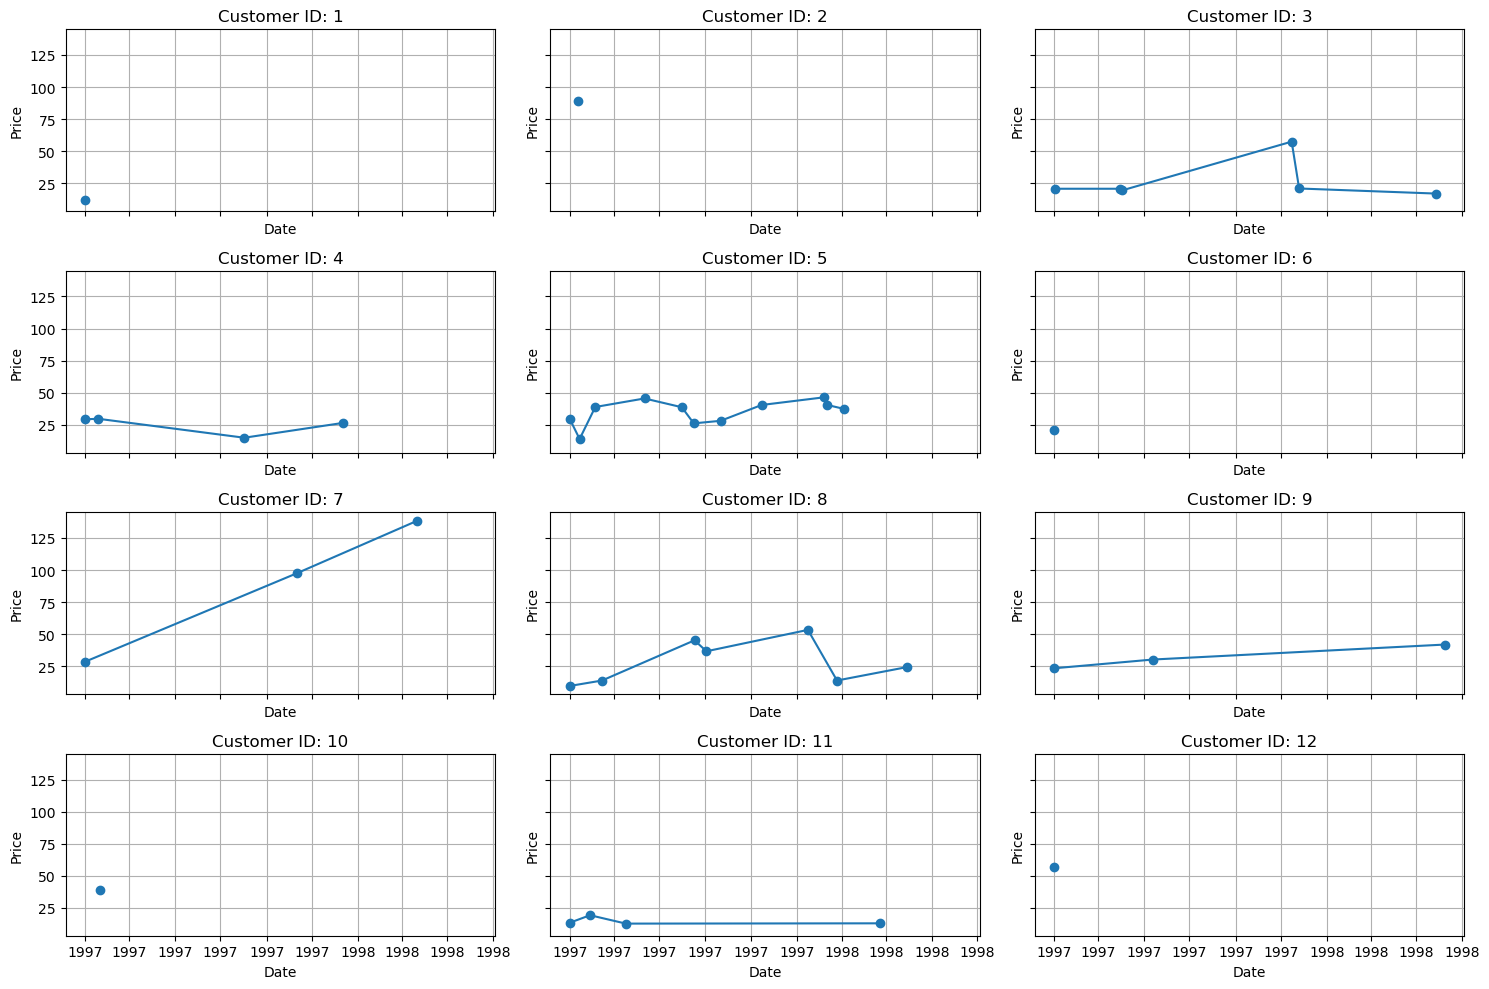

In [15]:
# Number of unique customers in the subset
unique_customers = cdnow_cust_id_subset_df['customer_id'].nunique()

# Define the number of rows and columns for the subplots
num_cols = 3
num_rows = (unique_customers + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, (customer_id, group) in zip(axes, cdnow_cust_id_subset_df.groupby('customer_id')):
    ax.plot(group['date'], group['price'], marker='o', linestyle='-')
    ax.set_title(f'Customer ID: {customer_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    ax.grid(True) 

# Remove any empty subplots
for i in range(unique_customers, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



# 3.0 FEATURE ENGINEERING

Frame problem:

- What will the customers spend in the next 90-days? (Regression)
- What is the probability of a customer to make a purchase in the next 90-days? (Classification)

## 3.1 TIME SPLITTING (STAGE 1)

In [16]:
n_days = 90
max_date = cdnow_df['date'].max()

# Calculate the cutoff date
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

In [17]:
temporal_in_df = cdnow_df[cdnow_df['date'] <= cutoff]
temporal_out_df = cdnow_df[cdnow_df['date'] > cutoff]

In [18]:
temporal_in_df.head(3)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00


In [19]:
temporal_out_df.head(3)

,customer_id,date,quantity,price
8,3,1998-05-28,1,16.99
38,9,1998-06-08,2,41.98
68,25,1998-04-17,1,12.99


## 3.2 FEATURE ENGINEERING (RFM)

### Make Targets From Data

In [20]:
targets_df = (
    temporal_out_df
    .drop(['quantity','date'], axis=1) # must drop date to .sum()
    .groupby('customer_id')
    .sum()
    .rename({'price': 'spend_90_total'}, axis=1)
    .assign(spend_90_flag=1)  # Add a new column 'spend_90_flag' with value 1
)

In [21]:
targets_df.head(3)

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1


In [22]:
# From almost 70k to 3301
targets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3301 entries, 3 to 23561
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   spend_90_total  3301 non-null   float64
 1   spend_90_flag   3301 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 77.4 KB


### Make Recency (Date) Features From 'in' Data

In [23]:
max_date = temporal_in_df['date'].max()

In [24]:
recency_features_df = (
    temporal_in_df
    #.drop(['quantity','price'], axis=1)
    [['customer_id','date']]
    .groupby('customer_id')
    .apply(lambda x: (x['date'].max() - max_date).days, include_groups=False)
    .to_frame(name='recency') # <- cause customer_id to become index
    .set_axis(['recency'], axis=1)
)

In [25]:
recency_features_df.head(3)

,recency
customer_id,
1,-455
2,-444
3,-127


In [26]:
recency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   recency  23570 non-null  int64
dtypes: int64(1)
memory usage: 368.3 KB


### Make Frequency (Count) Features From 'in' Data

In [27]:
frequency_features_df = (
    temporal_in_df[['customer_id','date']]
    .groupby('customer_id')
    .count()
    .set_axis(['frequency'], axis=1)
)

In [28]:
frequency_features_df.head()

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11


In [29]:
frequency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   frequency  23570 non-null  int64
dtypes: int64(1)
memory usage: 368.3 KB


### Make Price (Monetary) Features From 'in' Data

In [30]:
price_features_df = (
    temporal_in_df
    .groupby('customer_id')
    .aggregate({'price':['sum','mean']})
    .set_axis(['price_sum','price_mean'], axis=1)
)

In [31]:
price_features_df.head(3)

,price_sum,price_mean
customer_id,,
1,11.77,11.770
2,89.00,44.500
3,139.47,27.894


In [32]:
price_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price_sum   23570 non-null  float64
 1   price_mean  23570 non-null  float64
dtypes: float64(2)
memory usage: 552.4 KB


### 3.3 Combine Features

In [33]:
features_df = (
    pd.concat(
        [recency_features_df,frequency_features_df,price_features_df],axis=1
    )
    .merge(
        targets_df,
        left_index=True,
        right_index=True,
        how='left'
    )
    .fillna(0) # Customers that did not make a purchase show as NaN
)

In [34]:
features_df.head(3)

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455,1,11.77,11.770,0.00,0.0
2,-444,2,89.00,44.500,0.00,0.0
3,-127,5,139.47,27.894,16.99,1.0


In [35]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         23570 non-null  int64  
 1   frequency       23570 non-null  int64  
 2   price_sum       23570 non-null  float64
 3   price_mean      23570 non-null  float64
 4   spend_90_total  23570 non-null  float64
 5   spend_90_flag   23570 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3 MB


# 4.0 MACHINE LEARNING

## Imports

In [36]:
import pandas as pd
# import cudf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
import numpy as np

In [37]:
# !nvidia-smi

## 4.1 Next 90-Day Spend Prediction (Regression)

In [74]:
X = features_df[['recency','frequency','price_sum','price_mean']]

In [75]:
y_spend = features_df['spend_90_total']

In [76]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_spend, test_size=0.2, random_state=42)

In [77]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((18856, 4), (4714, 4), (18856,), (4714,))

In [42]:
# Define the XGBRegressor with hyperparameters
xgb_reg_spec = XGBRegressor(
    objective='reg:squarederror',
    # tree_method='hist', # gpu_hist depreciated
    # device='cuda', # now use this
    # gpu_id=0,
    random_state=42
)

xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'lambda': [1, 1.5, 2, 3]   # L2 regularization term on weights
}

# Grid search for XGBRegressor
xgbreg_grid_search = GridSearchCV(
    estimator=xgb_reg_spec,
    param_grid=xgb_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5,
    n_jobs=-1
)

In [43]:
# Fit the model using the training data
xgbreg_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.5, 1],
                         'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                         'lambda': [1, 1.5, 2, 3],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error')

In [44]:
# Define the CatBoostRegressor with hyperparameters
cat_reg_spec = CatBoostRegressor(
    loss_function='MAE',
    # task_type='GPU',
    random_seed=42,
    verbose=0  # Suppress CatBoost output
)

cat_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Grid search for CatBoostRegressor
cat_grid_search = GridSearchCV(
    estimator=cat_reg_spec,
    param_grid=cat_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5,
    n_jobs=6
)

In [45]:
# Fit the model using the training data
cat_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb414d4de10>,
             n_jobs=6,
             param_grid={'depth': [3, 4, 5, 6], 'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5, 7],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3]},
             scoring='neg_mean_absolute_error')

## Regression Interpretation

In [46]:
# Evaluate XGBRegressor on test set
xgb_best_model = xgbreg_grid_search.best_estimator_
xgb_y_pred = xgb_best_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
print("XGBRegressor Best MAE: ", xgb_mae)

# Evaluate CatBoostRegressor on test set
cat_reg_best_model = cat_grid_search.best_estimator_
cat_y_pred = cat_reg_best_model.predict(X_test)
cat_mae = mean_absolute_error(y_test, cat_y_pred)
print("CatBoostRegressor Best MAE: ", cat_mae)

# Print best parameters
print("Best parameters for XGBRegressor: ", xgbreg_grid_search.best_params_)
print("Best parameters for CatBoostRegressor: ", cat_grid_search.best_params_)


XGBRegressor Best MAE:  10.80781903628429
CatBoostRegressor Best MAE:  8.07588626966046
Best parameters for XGBRegressor:  {'alpha': 0.5, 'colsample_bytree': 1.0, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Best parameters for CatBoostRegressor:  {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.2}


In [47]:
# Additional statistics for the target variable
print(f"Range of target variable: {y_spend.min()} to {y_spend.max()}")
print(f"Mean of target variable: {y_spend.mean()}")
print(f"Standard deviation of target variable: {y_spend.std()}")

Range of target variable: 0.0 to 2512.91
Mean of target variable: 8.949271955876114
Standard deviation of target variable: 43.65695254305198


CatBoostRegressor has a better MAE than XGBRegressor and will be used to asses model fit.

**MAE vs. Mean of Target Variable:**

The MAE (8.07) being lower than the mean of the target variable (8.94) suggests that, on average, the errors your model makes are smaller than the average value of the target variable. This is a good sign, indicating that the model is not making large errors consistently.

**MAE vs. Standard Deviation of Target Variable:**

The standard deviation (43.65) is a measure of the spread or variability in the target variable. An MAE of 8.07 is significantly lower than the standard deviation, indicating that the model's errors are relatively small compared to the variability in the target data. This means the model is capturing a significant amount of the variability in the data and making predictions that are fairly close to the actual values.

## 4.2 Next 90-Day Spend Probability (Binary Classification)

In [78]:
y_prob = features_df['spend_90_flag']

In [79]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_prob, test_size=0.2, random_state=42)

In [80]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((18856, 4), (4714, 4), (18856,), (4714,))

In [50]:
# Define the XGBClassifier with hyperparameters
xgb_class_spec = XGBClassifier(
    objective='binary:logistic',
    # tree_method='hist', # gpu_hist depreciated
    # device='cuda', # now use this
    # gpu_id=0,
    random_state=42
)

xgb_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'lambda': [1, 1.5, 2, 3]   # L2 regularization term on weights
}

# Grid search for XGBClassifier
xgb_class_grid_search = GridSearchCV(
    estimator=xgb_class_spec,
    param_grid=xgb_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=-1
)

In [51]:
# Fit the model using the training data
xgb_class_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.5, 1],
                         'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                         'lambda': [1, 1.5, 2, 3],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [52]:
# Define the CatBoostClassifier with hyperparameters
cat_class_spec = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0 
)

# Define the hyperparameter grid
cat_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Define the GridSearchCV object
cat_class_grid_search = GridSearchCV(
    estimator=cat_class_spec,
    param_grid=cat_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=6
)


In [53]:
# Fit the model using the training data
cat_class_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fb3d5199a90>,
             n_jobs=6,
             param_grid={'depth': [3, 4, 5, 6], 'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5, 7],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3]},
             scoring='roc_auc')

## Classification Interpretation

In [54]:
from sklearn.metrics import roc_auc_score, mean_absolute_error

In [55]:
# Evaluate XGBClassifier on test set
xgb_best_model = xgb_class_grid_search.best_estimator_
xgb_y_pred_proba = xgb_best_model.predict_proba(X_test)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba)
print("XGBClassifier Best ROC AUC: ", xgb_roc_auc)

# Evaluate CatBoostClassifier on test set
cat_class_best_model = cat_class_grid_search.best_estimator_
cat_y_pred_proba = cat_class_best_model.predict_proba(X_test)[:, 1]
cat_roc_auc = roc_auc_score(y_test, cat_y_pred_proba)
print("CatBoostClassifier Best ROC AUC: ", cat_roc_auc)

# Print best parameters
print("Best parameters for XGBClassifier: ", xgb_class_grid_search.best_params_)
print("Best parameters for CatBoostClassifier: ", cat_class_grid_search.best_params_)

XGBClassifier Best ROC AUC:  0.8456916660776137
CatBoostClassifier Best ROC AUC:  0.8466781458377513
Best parameters for XGBClassifier:  {'alpha': 0.1, 'colsample_bytree': 0.8, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
Best parameters for CatBoostClassifier:  {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.01}


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

xgb_class_y_pred = xgb_best_model.predict(X_test)
cat_class_y_pred = cat_class_best_model.predict(X_test)

print("XGBClassifier Accuracy: ", accuracy_score(y_test, xgb_class_y_pred))
print("XGBClassifier Precision: ", precision_score(y_test, xgb_class_y_pred))
print("XGBClassifier Recall: ", recall_score(y_test, xgb_class_y_pred))
print("XGBClassifier F1 Score: ", f1_score(y_test, xgb_class_y_pred))
print('')
print("CatBoostClassifier Accuracy: ", accuracy_score(y_test, cat_class_y_pred))
print("CatBoostClassifier Precision: ", precision_score(y_test, cat_class_y_pred))
print("CatBoostClassifier Recall: ", recall_score(y_test, cat_class_y_pred))
print("CatBoostClassifier F1 Score: ", f1_score(y_test, cat_class_y_pred))

XGBClassifier Accuracy:  0.8792957148918116
XGBClassifier Precision:  0.6757679180887372
XGBClassifier Recall:  0.29464285714285715
XGBClassifier F1 Score:  0.41036269430051814

CatBoostClassifier Accuracy:  0.8807806533729317
CatBoostClassifier Precision:  0.6740506329113924
CatBoostClassifier Recall:  0.3169642857142857
CatBoostClassifier F1 Score:  0.4311740890688259


**Model Assesment**

* Accuracy: Both models perform similarly.
* Precision: Both models have similar precision, indicating a similar rate of false positives.
* Recall: CatBoostClassifier has a higher recall, meaning it is better at identifying true positives.
* F1 Score: CatBoostClassifier has a higher F1 score, indicating a better balance between precision and recall.

**Conclusion:** Overall, based on these metrics, CatBoostClassifier slightly outperforms XGBClassifier due to its better recall and F1 score.

## 4.3 FEATURE IMPORTANCE

### Regression

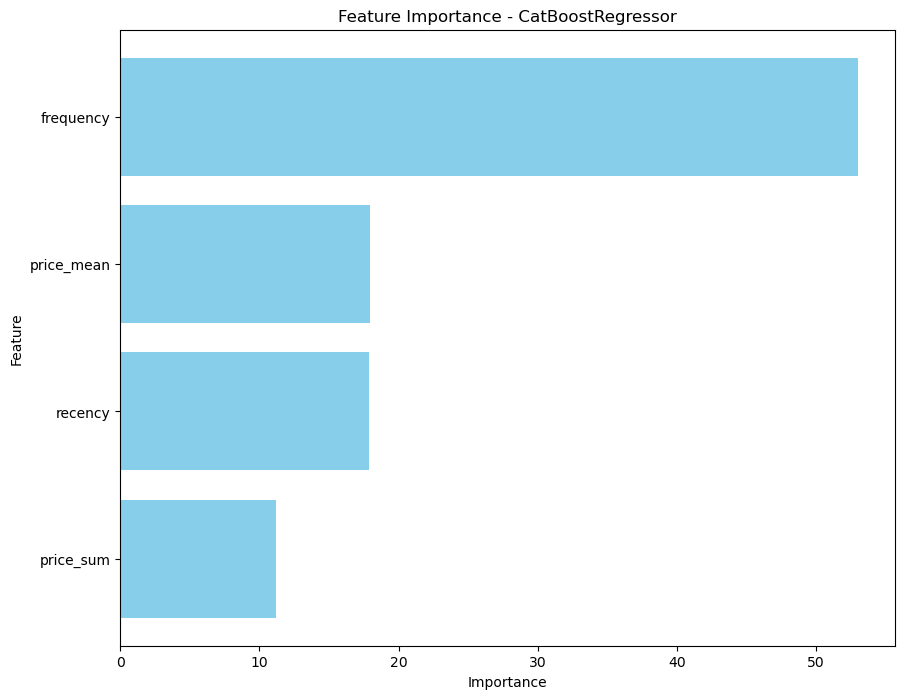

In [58]:
# Extract feature importance from CatBoostRegressor
cat_reg_feature_importance = cat_reg_best_model.get_feature_importance()
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame for visualization
cat_reg_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_reg_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cat_reg_importance_df['Feature'], cat_reg_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoostRegressor')
plt.gca().invert_yaxis()
plt.show()

### Classification

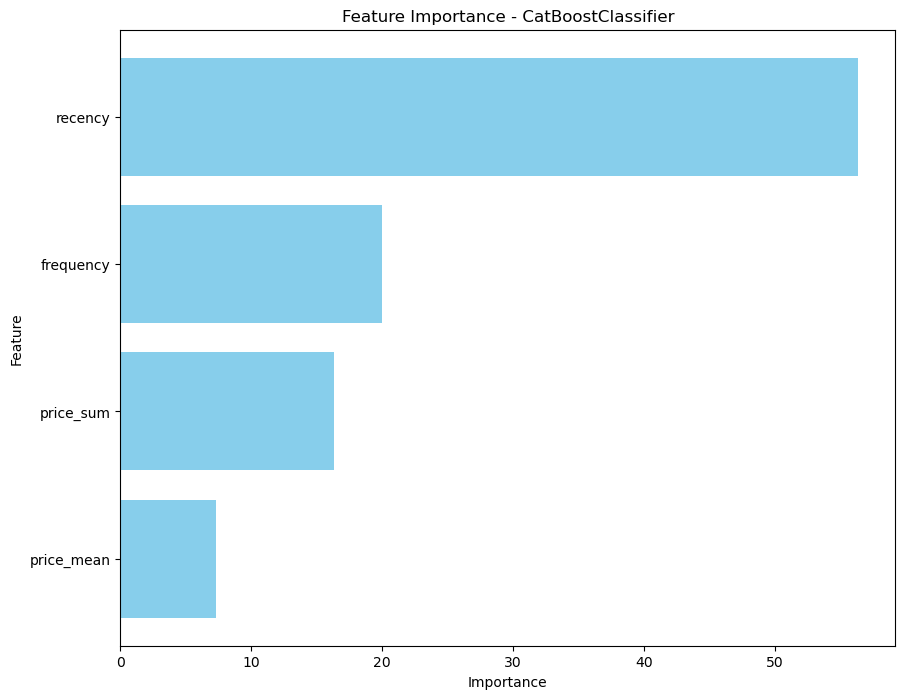

In [59]:
# Extract feature importance from CatBoostClassifier
cat_class_feature_importance = cat_class_best_model.get_feature_importance()
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame for visualization
cat_class_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_class_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cat_class_importance_df['Feature'], cat_class_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoostClassifier')
plt.gca().invert_yaxis()
plt.show()

## 4.4 FINAL MODEL

### Train Final Model

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# Assuming features_df is your original DataFrame and includes 'spend_90_flag'
y_class = features_df['spend_90_flag']
X = features_df.drop(columns=['spend_90_flag'])  # Drop the target variable to get feature set

# Define and fit the CatBoostClassifier on the entire dataset
cat_class_spec = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0 
)

cat_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cat_class_grid_search = GridSearchCV(
    estimator=cat_class_spec,
    param_grid=cat_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=6
)
cat_class_grid_search.fit(X, y_class)

# Generate predictions for the entire dataset
cat_class_best_model = cat_class_grid_search.best_estimator_
cat_class_y_pred_proba = cat_class_best_model.predict_proba(X)[:, 1]

# Create DataFrame for the predicted probabilities
cat_class_predictions_df = pd.DataFrame(cat_class_y_pred_proba, columns=['pred_prob'])

# Assuming you have a 'spend_amount' target variable for regression in features_df
y_reg = features_df['spend_90_total']

# Define and fit the CatBoostRegressor on the entire dataset
cat_reg_spec = CatBoostRegressor(
    loss_function='MAE',
    random_seed=42,
    verbose=0 
)

cat_reg_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cat_reg_grid_search = GridSearchCV(
    estimator=cat_reg_spec,
    param_grid=cat_reg_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5,
    n_jobs=6
)
cat_reg_grid_search.fit(X, y_reg)

# Generate regression predictions for the entire dataset
cat_reg_best_model = cat_reg_grid_search.best_estimator_
cat_reg_y_pred = cat_reg_best_model.predict(X)

### Combine Features

In [84]:
# Create DataFrame for the regression predictions
cat_reg_predictions_df = pd.DataFrame(cat_reg_y_pred, columns=['pred_spend'])

# Ensure that the DataFrames have the same number of rows
assert len(cat_class_predictions_df) == len(cat_reg_predictions_df) == len(features_df), "Mismatch in number of rows"

# Combine the predicted probabilities, regression predictions, and original features
predictions_df = pd.concat(
    [
        cat_class_predictions_df.reset_index(drop=True),
        cat_reg_predictions_df.reset_index(drop=True),
        features_df.reset_index(drop=True)
    ], axis=1
)

In [85]:
predictions_df

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.184004,2.311268e-07,-455,1,11.77,11.770000,0.00,0.0
1,0.183944,-1.074754e-06,-444,2,89.00,44.500000,0.00,0.0
2,0.816598,1.728146e+01,-127,5,139.47,27.894000,16.99,1.0
3,0.184264,-5.325798e-07,-110,4,100.50,25.125000,0.00,0.0
4,0.184473,-3.241534e-05,-88,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...
23565,0.183952,-2.845671e-07,-372,1,36.00,36.000000,0.00,0.0
23566,0.183993,-2.852772e-07,-372,1,20.97,20.970000,0.00,0.0
23567,0.184034,2.073337e-07,-344,3,121.70,40.566667,0.00,0.0
23568,0.184000,-5.719496e-07,-372,1,25.74,25.740000,0.00,0.0


### Save Models and Files

In [87]:
predictions_df.to_pickle('../artifacts/predictions_df.pkl')

In [90]:
cat_reg_importance_df.to_pickle('../artifacts/cat_reg_importance_df.pkl')

In [89]:
cat_class_importance_df.to_pickle('../artifacts/cat_class_importance_df.pkl')